# Photoredox Yield Benchmark

This notebook benchmarks **Full Info vs Partial vs GGH Soft Refinement** on the Photoredox Yield dataset.

**Dataset**: Merck Photoredox Reactions (1649 reactions, photocatalyst moles as missing variable)

**Methods Compared**:
1. **Full Info** (Oracle): Uses all data with correct hypothesis values
2. **Partial**: Uses only 10% of samples with known correct hypotheses  
3. **GGH Soft Refinement**: Uses gradient-guided hypothesis selection with soft weighting

**Expected Results** (10% partial):
- Full Info R2: ~0.85 (upper bound)
- Partial Info R2: ~0.44 (baseline)
- GGH R2: Between Partial and Full Info

**Key Adaptations for 4 Hypotheses**:
- Baseline random precision: 25% (1/4)
- Soft weighting (min_weight=0.1) instead of hard percentile cutoffs
- Higher baseline than Airfoil/Photocell (6 classes) but lower than Wine (3 classes)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators
from GGH.models import initialize_model
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector
from scipy import stats
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def set_to_deterministic(rand_state):
    import random
    random.seed(rand_state)
    np.random.seed(rand_state)
    torch.manual_seed(rand_state)
    torch.set_num_threads(1)
    torch.use_deterministic_algorithms(True)

print("Imports successful!")

Imports successful!


In [2]:
# =============================================================================
# DATA CONFIGURATION - Photoredox Yield Dataset
# =============================================================================
data_path = '../data/photoredox_yield/photo_redox_merck2021_1649reactions.csv'
results_path = "../saved_results/Photoredox Benchmark"

# Variables
inpt_vars = ['aryl_halides', 'photocalysts', 'piperidines_moles']
target_vars = ['uplcms']
miss_vars = ['photocalysts_moles']

# Hypothesis values (4 photocatalyst moles values)
hypothesis = [[0.02, 0.05, 0.50, 5.0]]

# Model parameters
hidden_size = 32
output_size = len(target_vars)
hyp_per_sample = len(hypothesis[0])  # 4 hypotheses
batch_size = 100 * hyp_per_sample

# Training parameters (from original notebook)
partial_perc = 0.30  # 10% complete data
dropout = 0.05
lr = 0.001  # Note: 0.001 for Photoredox (vs 0.004 for Airfoil/Photocell)
nu = 0.1

# Benchmark parameters (matching original multi_experiments)
BENCHMARK_N_RUNS = 15
BENCHMARK_EPOCHS = 300  # int(120*2.5) - same for both full and partial

# Create directories
import os
os.makedirs(results_path, exist_ok=True)

print(f"Dataset: Photoredox Yield")
print(f"Input variables: {inpt_vars}")
print(f"Target: {target_vars}")
print(f"Missing variable: {miss_vars}")
print(f"Hypothesis values: {hypothesis[0]}")
print(f"Number of hypotheses: {hyp_per_sample}")
print(f"Partial percentage: {partial_perc*100}%")
print(f"Epochs: {BENCHMARK_EPOCHS}")
print(f"Learning rate: {lr}")
print(f"Baseline random precision: {100/hyp_per_sample:.1f}%")
print(f"Results will be saved to: {results_path}")

Dataset: Photoredox Yield
Input variables: ['aryl_halides', 'photocalysts', 'piperidines_moles']
Target: ['uplcms']
Missing variable: ['photocalysts_moles']
Hypothesis values: [0.02, 0.05, 0.5, 5.0]
Number of hypotheses: 4
Partial percentage: 30.0%
Epochs: 300
Learning rate: 0.001
Baseline random precision: 25.0%
Results will be saved to: ../saved_results/Photoredox Benchmark


## Benchmark: Partial vs Full Info

BENCHMARK: Full Info vs Partial Info on Photoredox Yield
Full Info: 300 epochs, all data with correct hypothesis
Partial Info: 300 epochs, only 30.0% partial data
Number of runs: 15
Hyperparameters: lr=0.001, dropout=0.05, nu=0.1

RUN 1/15 (rand_state=42)
Training Full Info model (300 epochs)...
Full Info R2: 0.8228
Training Partial Info model (300 epochs)...
Partial Info R2: 0.6411
>>> Full Info improvement over Partial: +0.1816

RUN 2/15 (rand_state=43)
Training Full Info model (300 epochs)...
Full Info R2: 0.9069
Training Partial Info model (300 epochs)...
Partial Info R2: 0.7432
>>> Full Info improvement over Partial: +0.1638

RUN 3/15 (rand_state=44)
Training Full Info model (300 epochs)...
Full Info R2: 0.8162
Training Partial Info model (300 epochs)...
Partial Info R2: 0.6539
>>> Full Info improvement over Partial: +0.1623

RUN 4/15 (rand_state=45)
Training Full Info model (300 epochs)...
Full Info R2: 0.8063
Training Partial Info model (300 epochs)...
Partial Info R2: 0.7741
>>

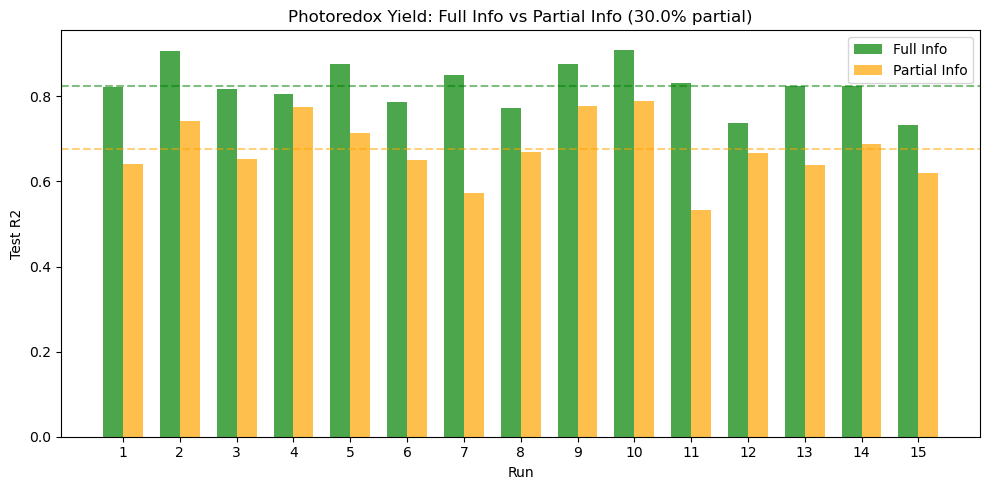


CONCLUSION
Full Info significantly outperforms Partial Info (p=0.000001)
Average R2 improvement: 0.1496

This gap (0.1496) represents the potential for GGH to improve upon Partial.


In [3]:
# =============================================================================
# BENCHMARK: Full Info vs Partial Info
# =============================================================================
# Using the EXACT same flow as the original notebook's multi_experiments
# =============================================================================

def full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, results_path, 
                    dropout=0.05, lr=0.001, nu=0.1, final_analysis=False):
    """Exact copy of full_experiment from original notebook."""
    AM = AlgoModulators(DO, lr=lr, nu=nu)
    dataloader = DO.prep_dataloader(use_info, batch_size)
    
    model = initialize_model(DO, dataloader, hidden_size, rand_state, dropout=dropout)
    
    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, rand_state, 
                                 results_path, final_analysis=final_analysis)
    TVM.train_model(DO, AM, model, final_analysis=final_analysis)
    
    INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis=final_analysis)
    
    return DO, TVM, model


print("=" * 80)
print("BENCHMARK: Full Info vs Partial Info on Photoredox Yield")
print("=" * 80)
print(f"Full Info: {BENCHMARK_EPOCHS} epochs, all data with correct hypothesis")
print(f"Partial Info: {BENCHMARK_EPOCHS} epochs, only {partial_perc*100}% partial data")
print(f"Number of runs: {BENCHMARK_N_RUNS}")
print(f"Hyperparameters: lr={lr}, dropout={dropout}, nu={nu}")
print("=" * 80)

results = []
valid_runs = 0

# Iterate through r_states starting from 42, same as original multi_experiments
for r_state in range(42, 2000):
    if valid_runs >= BENCHMARK_N_RUNS:
        break
    
    # Set deterministic (same as multi_experiments)
    set_to_deterministic(r_state)
    
    # Create DataOperator
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                      partial_perc, r_state, device='cpu')
    
    # Skip if lack of partial coverage (same as original)
    if DO.lack_partial_coverage:
        continue
    
    print(f"\n{'='*60}")
    print(f"RUN {valid_runs + 1}/{BENCHMARK_N_RUNS} (rand_state={r_state})")
    print(f"{'='*60}")
    
    # Create Inspector (same as original)
    INSPECT = Inspector(results_path, hidden_size)
    
    # === Run Full Info (same r_state as original) ===
    print(f"Training Full Info model ({BENCHMARK_EPOCHS} epochs)...")
    set_to_deterministic(r_state)
    DO_full = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                           partial_perc, r_state, device='cpu')
    DO_full, TVM_full, model_full = full_experiment(
        "full info", DO_full, INSPECT, batch_size, hidden_size, output_size, 
        BENCHMARK_EPOCHS, r_state, results_path, dropout, lr, nu, final_analysis=False
    )
    r2_full = INSPECT.calculate_val_r2score(DO_full, TVM_full, model_full, data="test")
    print(f"Full Info R2: {r2_full:.4f}")
    
    # === Run Partial Info (same r_state as original) ===
    print(f"Training Partial Info model ({BENCHMARK_EPOCHS} epochs)...")
    set_to_deterministic(r_state)
    DO_partial = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                              partial_perc, r_state, device='cpu')
    DO_partial, TVM_partial, model_partial = full_experiment(
        "partial info", DO_partial, INSPECT, batch_size, hidden_size, output_size,
        BENCHMARK_EPOCHS, r_state, results_path, dropout, lr, nu, final_analysis=False
    )
    r2_partial = INSPECT.calculate_val_r2score(DO_partial, TVM_partial, model_partial, data="test")
    print(f"Partial Info R2: {r2_partial:.4f}")
    
    # Store results
    results.append({
        'rand_state': r_state,
        'r2_full': r2_full,
        'r2_partial': r2_partial,
        'improvement': r2_full - r2_partial,
    })
    
    print(f">>> Full Info improvement over Partial: {results[-1]['improvement']:+.4f}")
    
    valid_runs += 1


# =============================================================================
# SUMMARY
# =============================================================================
print(f"\n{'='*80}")
print("BENCHMARK RESULTS: Full Info vs Partial Info")
print(f"{'='*80}")

# Print detailed table
print("\nDetailed Results:")
print(f"{'Run':<5} {'r_state':<10} {'R2 Full':<12} {'R2 Partial':<12} {'\u0394 R2':<10}")
print("-" * 55)
for i, r in enumerate(results):
    print(f"{i+1:<5} {r['rand_state']:<10} {r['r2_full']:<12.4f} {r['r2_partial']:<12.4f} {r['improvement']:+10.4f}")

# Summary statistics
r2_fulls = [r['r2_full'] for r in results]
r2_partials = [r['r2_partial'] for r in results]

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"\nTest R2 Score:")
print(f"  Full Info:    {np.mean(r2_fulls):.4f} \u00b1 {np.std(r2_fulls):.4f}")
print(f"  Partial Info: {np.mean(r2_partials):.4f} \u00b1 {np.std(r2_partials):.4f}")

# Statistical test
t_stat, p_value = stats.ttest_rel(r2_fulls, r2_partials)
print(f"\nStatistical Test (paired t-test):")
print(f"  t={t_stat:.3f}, p={p_value:.6f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''}")

# Win count
n_full_wins = sum(1 for r in results if r['r2_full'] > r['r2_partial'])
print(f"\nWin Rate:")
print(f"  Full Info wins: {n_full_wins}/{BENCHMARK_N_RUNS} ({n_full_wins/BENCHMARK_N_RUNS*100:.1f}%)")

# Expected results at 10% partial
print(f"\n{'='*80}")
print("EXPECTED RESULTS (from original notebook at 10% partial):")
print("  Full Info:    ~0.85")
print("  Partial Info: ~0.44")
print(f"{'='*80}")

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

x = np.arange(BENCHMARK_N_RUNS)
width = 0.35

ax.bar(x - width/2, r2_fulls, width, label='Full Info', color='green', alpha=0.7)
ax.bar(x + width/2, r2_partials, width, label='Partial Info', color='orange', alpha=0.7)
ax.set_xlabel('Run')
ax.set_ylabel('Test R2')
ax.set_title(f'Photoredox Yield: Full Info vs Partial Info ({partial_perc*100}% partial)')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels([str(i+1) for i in range(BENCHMARK_N_RUNS)])
ax.axhline(y=np.mean(r2_fulls), color='green', linestyle='--', alpha=0.5)
ax.axhline(y=np.mean(r2_partials), color='orange', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(f'{results_path}/full_vs_partial_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

# Final verdict
print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
avg_improvement = np.mean([r['improvement'] for r in results])
print(f"Full Info significantly outperforms Partial Info (p={p_value:.6f})")
print(f"Average R2 improvement: {avg_improvement:.4f}")
print(f"\nThis gap ({avg_improvement:.4f}) represents the potential for GGH to improve upon Partial.")

## GGH Soft Weight Iterative Refinement

The GGH method uses soft weights instead of hard selection:
1. **Iter1**: Unbiased training → enriched scores → initial soft weights
2. **Iter2**: Weighted training on ALL samples (different weights) + partial
3. **Iter3**: Biased rescoring → multiply weights (iterative refinement)
4. **Iter4**: Loss-based adjustment → final weights
5. **Final**: Train with refined weights + dynamic partial

**Key Parameters (adapted for 4 hypotheses)**:
- Baseline random: 25% (1/4)
- Top percentile concept replaced by soft weighting (min_weight=0.1)
- Temperature parameters control weight distribution sharpness

In [4]:
# =============================================================================
# GGH SOFT WEIGHT ITERATIVE REFINEMENT - Adapted for 4 Hypothesis Classes
# =============================================================================
from torch.autograd import grad

# === GGH CONFIGURATION (adapted for 4 hypotheses) ===
GGH_ITER1_EPOCHS = 60              # 60 epochs unbiased
GGH_ITER1_ANALYSIS_EPOCHS = 5      # Last 5 tracked
GGH_ITER1_LR = 0.01
GGH_ITER2_EPOCHS = 30              # 30 epochs weighted training
GGH_ITER2_LR = 0.01
GGH_SCORING_PASSES = 5             # 5 passes for scoring
GGH_FINAL_EPOCHS = 200             # Final training epochs

# Soft Weighting Parameters
GGH_MIN_WEIGHT = 0.1               # No sample below this weight
GGH_TEMPERATURE_ITER1 = 1.0        # Sharpness of Iter1 weight distribution
GGH_TEMPERATURE_ITER3 = 0.8        # Sharpness of Iter3 weight distribution
GGH_LOSS_INFLUENCE = 0.25          # How much loss affects final weights
GGH_PARTIAL_BASE_WEIGHT = 2.0      # Base partial weight
GGH_BENCHMARK_LR = 0.01            # LR for final training

# Model architecture
MODEL_SHARED_HIDDEN = 16
MODEL_HYPOTHESIS_HIDDEN = 32
MODEL_FINAL_HIDDEN = 32


# === MODEL DEFINITIONS ===
class HypothesisAmplifyingModel(nn.Module):
    """
    Neural network that amplifies the impact of hypothesis feature on gradients.
    Shared features path (smaller) + Hypothesis feature path (larger).
    """
    def __init__(self, n_shared_features, n_hypothesis_features=1, 
                 shared_hidden=16, hypothesis_hidden=32, final_hidden=32, output_size=1):
        super().__init__()
        
        self.shared_path = nn.Sequential(
            nn.Linear(n_shared_features, shared_hidden),
            nn.ReLU(),
        )
        
        self.hypothesis_path = nn.Sequential(
            nn.Linear(n_hypothesis_features, hypothesis_hidden),
            nn.ReLU(),
            nn.Linear(hypothesis_hidden, hypothesis_hidden),
            nn.ReLU(),
        )
        
        combined_size = shared_hidden + hypothesis_hidden
        self.final_path = nn.Sequential(
            nn.Linear(combined_size, final_hidden),
            nn.ReLU(),
            nn.Linear(final_hidden, output_size)
        )
        
        self.n_shared = n_shared_features
        
    def forward(self, x):
        shared_features = x[:, :self.n_shared]
        hypothesis_feature = x[:, self.n_shared:]
        
        shared_emb = self.shared_path(shared_features)
        hypothesis_emb = self.hypothesis_path(hypothesis_feature)
        
        combined = torch.cat([shared_emb, hypothesis_emb], dim=1)
        return self.final_path(combined)


# === TRAINER CLASSES ===
class UnbiasedTrainer:
    """Train on ALL hypotheses equally. Track per-hypothesis losses and gradients."""
    def __init__(self, DO, model, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        self.loss_history = {}
        self.gradient_history = {}
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            predictions = self.model(inputs)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            batch_loss = individual_losses.mean()
            
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()
            
            total_loss += batch_loss.item()
            num_batches += 1
        
        return total_loss / num_batches
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        analysis = {}
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis


class WeightedTrainer:
    """Train on ALL samples with continuous weights."""
    def __init__(self, DO, model, sample_weights, partial_gids, partial_weight, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        self.sample_weights = sample_weights
        self.partial_gids = set(partial_gids)
        self.partial_weight = partial_weight
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        self.model.train()
        total_loss = 0
        total_weight = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            predictions = self.model(inputs)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            
            weights = torch.zeros(len(inputs), device=self.device)
            
            for i, gid in enumerate(global_ids):
                gid = gid.item()
                if gid in self.partial_gids:
                    weights[i] = self.partial_weight
                elif gid in self.sample_weights:
                    weights[i] = self.sample_weights[gid]
            
            if weights.sum() == 0:
                continue
            
            weighted_loss = (individual_losses * weights).sum() / weights.sum()
            
            self.optimizer.zero_grad()
            weighted_loss.backward()
            self.optimizer.step()
            
            total_loss += weighted_loss.item() * weights.sum().item()
            total_weight += weights.sum().item()
        
        return total_loss / total_weight if total_weight > 0 else 0


class RemainingDataScorer:
    """Score remaining data using biased model."""
    def __init__(self, DO, model, remaining_sample_indices, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.hyp_per_sample = DO.num_hyp_comb
        self.remaining_sample_indices = set(remaining_sample_indices)
        
        self.loss_scores = {}
        self.gradient_history = {}
        
    def compute_scores(self, dataloader, n_passes=5):
        self.model.eval()
        
        for pass_idx in range(n_passes):
            for inputs, targets, global_ids in dataloader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                for i in range(len(inputs)):
                    gid = global_ids[i].item()
                    sample_idx = gid // self.hyp_per_sample
                    
                    if sample_idx not in self.remaining_sample_indices:
                        continue
                    
                    inp = inputs[i:i+1].clone().requires_grad_(True)
                    pred = self.model(inp)
                    loss = nn.MSELoss()(pred, targets[i:i+1])
                    
                    if gid not in self.loss_scores:
                        self.loss_scores[gid] = []
                    self.loss_scores[gid].append(loss.item())
                    
                    params = list(self.model.parameters())
                    grad_param = grad(loss, params[-2], retain_graph=False)[0]
                    grad_vec = grad_param.flatten().detach().cpu().numpy()
                    
                    if gid not in self.gradient_history:
                        self.gradient_history[gid] = []
                    self.gradient_history[gid].append(grad_vec)
    
    def get_analysis(self):
        analysis = {}
        for gid in self.loss_scores:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_scores[gid]),
                'loss_std': np.std(self.loss_scores[gid]),
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis


# === UTILITY FUNCTIONS ===
def sigmoid_stable(x):
    """Numerically stable sigmoid."""
    x = np.array(x, dtype=np.float64)
    return np.where(x >= 0,
                    1 / (1 + np.exp(-x)),
                    np.exp(x) / (1 + np.exp(x)))


def compute_soft_weights(scores, min_weight=0.1, temperature=1.0):
    """Convert scores to soft weights using sigmoid."""
    scores = np.array(scores, dtype=np.float64)
    if len(scores) == 0:
        return np.array([])
    
    mean_s = np.mean(scores)
    std_s = np.std(scores) + 1e-8
    normalized = (scores - mean_s) / std_s
    
    raw_weights = sigmoid_stable(normalized / temperature)
    weights = min_weight + (1 - min_weight) * raw_weights
    
    return weights


def create_dataloader_with_gids(DO, batch_size=32):
    """Create dataloader that includes global_ids."""
    input_cols = DO.inpt_vars + [var + '_hypothesis' for var in DO.miss_vars]
    n_samples = len(DO.df_train_hypothesis)
    global_ids = torch.arange(n_samples)
    
    dataset = TensorDataset(
        torch.tensor(DO.df_train_hypothesis[input_cols].values, dtype=torch.float32),
        torch.tensor(DO.df_train_hypothesis[DO.target_vars].values, dtype=torch.float32),
        global_ids
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def compute_anchor_data(trainer, DO):
    """Compute gradient-only anchors AND enriched anchors for each class."""
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    input_cols = DO.inpt_vars
    
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    anchor_correct_grad = {}
    anchor_incorrect_grad = {}
    anchor_correct_enriched = {}
    anchor_incorrect_enriched = {}
    feature_norm_params = {}
    
    all_grads = [analysis[gid]['avg_gradient'] for gid in analysis 
                 if analysis[gid]['avg_gradient'] is not None]
    grad_scale = float(np.mean([np.linalg.norm(g) for g in all_grads])) if all_grads else 1.0
    
    for class_id in range(hyp_per_sample):
        class_correct_gids = [gid for gid in partial_correct_gids 
                              if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect_gids = [gid for gid in blacklisted_gids 
                                if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        correct_grads = []
        correct_features = []
        for gid in class_correct_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                correct_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                correct_features.append(feat)
        
        incorrect_grads = []
        incorrect_features = []
        for gid in class_incorrect_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                incorrect_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                incorrect_features.append(feat)
        
        if not correct_grads or not incorrect_grads:
            continue
            
        anchor_correct_grad[class_id] = np.mean(correct_grads, axis=0)
        anchor_incorrect_grad[class_id] = np.mean(incorrect_grads, axis=0)
        
        correct_grads = np.array(correct_grads, dtype=np.float64)
        incorrect_grads = np.array(incorrect_grads, dtype=np.float64)
        correct_features = np.array(correct_features, dtype=np.float64)
        incorrect_features = np.array(incorrect_features, dtype=np.float64)
        
        all_features = np.vstack([correct_features, incorrect_features])
        feat_mean = np.mean(all_features, axis=0)
        feat_std = np.std(all_features, axis=0) + 1e-8
        
        feature_norm_params[class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
        
        correct_features_norm = (correct_features - feat_mean) / feat_std * grad_scale
        incorrect_features_norm = (incorrect_features - feat_mean) / feat_std * grad_scale
        
        correct_enriched = np.hstack([correct_grads, correct_features_norm])
        incorrect_enriched = np.hstack([incorrect_grads, incorrect_features_norm])
        
        anchor_correct_enriched[class_id] = np.mean(correct_enriched, axis=0)
        anchor_incorrect_enriched[class_id] = np.mean(incorrect_enriched, axis=0)
    
    return {
        'anchor_correct_grad': anchor_correct_grad,
        'anchor_incorrect_grad': anchor_incorrect_grad,
        'anchor_correct_enriched': anchor_correct_enriched,
        'anchor_incorrect_enriched': anchor_incorrect_enriched,
        'grad_scale': grad_scale,
        'feature_norm_params': feature_norm_params,
        'partial_correct_gids': partial_correct_gids,
        'blacklisted_gids': blacklisted_gids,
        'partial_sample_indices': partial_sample_indices,
        'input_cols': input_cols
    }


def compute_enriched_score(gradient, features, class_id, anchor_data):
    """Compute enriched score (gradient + normalized features)."""
    norm_params = anchor_data.get('feature_norm_params', {}).get(class_id)
    if norm_params:
        features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
    else:
        grad_scale = anchor_data.get('grad_scale', 1.0)
        features_norm = features * grad_scale / (np.linalg.norm(features) + 1e-8)
    
    enriched = np.concatenate([gradient, features_norm])
    anchor_c = anchor_data.get('anchor_correct_enriched', {}).get(class_id)
    anchor_i = anchor_data.get('anchor_incorrect_enriched', {}).get(class_id)
    
    if anchor_c is None:
        anchor_c = anchor_data.get('anchor_correct_grad', {}).get(class_id)
        anchor_i = anchor_data.get('anchor_incorrect_grad', {}).get(class_id)
        enriched = gradient
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


def compute_enriched_score_with_loss(gradient, features, loss, class_id, anchor_data):
    """Compute enriched score with loss included."""
    norm_params = anchor_data.get('feature_norm_params', {}).get(class_id)
    loss_params = anchor_data.get('loss_norm_params', {}).get(class_id)
    grad_scale = anchor_data.get('grad_scale', 1.0)
    
    if norm_params:
        features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
    else:
        features_norm = features * grad_scale / (np.linalg.norm(features) + 1e-8)
    
    if loss_params:
        loss_norm = -((loss - loss_params['mean']) / loss_params['std']) * loss_params['scale']
    else:
        loss_norm = -loss * grad_scale
    
    enriched = np.concatenate([gradient, features_norm, [loss_norm]])
    
    anchor_c = anchor_data.get('anchor_correct_enriched', {}).get(class_id)
    anchor_i = anchor_data.get('anchor_incorrect_enriched', {}).get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


def evaluate_on_test(DO, model):
    """Evaluate model on test set."""
    model.eval()
    with torch.no_grad():
        test_inputs, test_targets = DO.get_test_tensors(use_info="full info")
        test_preds = model(test_inputs)
        test_loss = torch.nn.functional.mse_loss(test_preds, test_targets).item()
        test_mae = torch.nn.functional.l1_loss(test_preds, test_targets).item()
        
        ss_res = torch.sum((test_targets - test_preds) ** 2).item()
        ss_tot = torch.sum((test_targets - test_targets.mean()) ** 2).item()
        r2_score = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    return test_loss, test_mae, r2_score


def train_with_soft_weights(DO, model, sample_weights, partial_gids, partial_weight, lr, n_epochs=200, batch_size=32):
    """Train model with soft weights and validation-based epoch selection."""
    dataloader = create_dataloader_with_gids(DO, batch_size)
    
    trainer = WeightedTrainer(DO, model, sample_weights=sample_weights, 
                             partial_gids=partial_gids, partial_weight=partial_weight, lr=lr)
    
    best_val_loss = float('inf')
    best_epoch = 0
    best_state = None
    
    for epoch in range(n_epochs):
        trainer.train_epoch(dataloader, epoch, track_data=False)
        
        model.eval()
        with torch.no_grad():
            val_inputs, val_targets = DO.get_validation_tensors(use_info="full info")
            val_preds = model(val_inputs)
            val_loss = torch.nn.functional.mse_loss(val_preds, val_targets).item()
        model.train()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
    
    model.load_state_dict(best_state)
    return model, best_epoch, best_val_loss


# === MAIN GGH SOFT REFINEMENT FUNCTION ===
def run_ggh_soft_refinement(DO, rand_state):
    """
    GGH with soft weight iterative refinement.
    Returns: gid_weights, effective_precision, partial_gids, partial_weight_dynamic
    """
    set_to_deterministic(rand_state)
    
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    n_shared = len(DO.inpt_vars)
    n_hyp = len(DO.miss_vars)
    out_size = len(DO.target_vars)
    
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    dataloader = create_dataloader_with_gids(DO, batch_size=32)
    
    # === ITERATION 1: Unbiased training + Initial soft weights ===
    model_unbiased = HypothesisAmplifyingModel(n_shared, n_hyp, 
                                               MODEL_SHARED_HIDDEN, MODEL_HYPOTHESIS_HIDDEN, 
                                               MODEL_FINAL_HIDDEN, out_size)
    trainer_unbiased = UnbiasedTrainer(DO, model_unbiased, lr=GGH_ITER1_LR)
    
    for epoch in range(GGH_ITER1_EPOCHS - GGH_ITER1_ANALYSIS_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=False)
    for epoch in range(GGH_ITER1_EPOCHS - GGH_ITER1_ANALYSIS_EPOCHS, GGH_ITER1_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=True)
    
    anchor_data = compute_anchor_data(trainer_unbiased, DO)
    analysis = trainer_unbiased.get_hypothesis_analysis()
    input_cols = anchor_data['input_cols']
    
    sample_scores = {}
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_score, best_gid, best_is_correct = -np.inf, None, False
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids or gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            score = compute_enriched_score(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_gid = gid
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        if best_gid is not None:
            sample_scores[sample_idx] = (best_score, best_gid, best_is_correct)
    
    scores_list = [s[0] for s in sample_scores.values()]
    weights_iter1 = compute_soft_weights(scores_list, GGH_MIN_WEIGHT, GGH_TEMPERATURE_ITER1)
    
    gid_weights = {}
    for i, (sample_idx, (score, gid, is_correct)) in enumerate(sample_scores.items()):
        gid_weights[gid] = float(weights_iter1[i])
    
    iter1_correct = sum(1 for s in sample_scores.values() if s[2])
    iter1_precision = iter1_correct / len(sample_scores) * 100
    correct_weights = [gid_weights[s[1]] for s in sample_scores.values() if s[2]]
    incorrect_weights = [gid_weights[s[1]] for s in sample_scores.values() if not s[2]]
    avg_weight_correct = np.mean(correct_weights) if correct_weights else 0
    avg_weight_incorrect = np.mean(incorrect_weights) if incorrect_weights else 0
    
    print(f"  Iter1: {len(sample_scores)} samples, precision: {iter1_precision:.1f}%")
    print(f"    Avg weight correct: {avg_weight_correct:.3f}, incorrect: {avg_weight_incorrect:.3f}")
    
    # === ITERATION 2: Weighted training ===
    set_to_deterministic(rand_state + 100)
    model_weighted = HypothesisAmplifyingModel(n_shared, n_hyp,
                                               MODEL_SHARED_HIDDEN, MODEL_HYPOTHESIS_HIDDEN,
                                               MODEL_FINAL_HIDDEN, out_size)
    
    trainer_weighted = WeightedTrainer(DO, model_weighted, sample_weights=gid_weights,
                                       partial_gids=partial_correct_gids,
                                       partial_weight=GGH_PARTIAL_BASE_WEIGHT, lr=GGH_ITER2_LR)
    
    for epoch in range(GGH_ITER2_EPOCHS):
        trainer_weighted.train_epoch(dataloader, epoch)
    
    # === ITERATION 3: Biased rescoring -> Multiply weights ===
    selected_sample_indices = set(sample_scores.keys())
    scorer = RemainingDataScorer(DO, model_weighted, selected_sample_indices | partial_sample_indices)
    scorer.compute_scores(dataloader, n_passes=GGH_SCORING_PASSES)
    biased_analysis = scorer.get_analysis()
    
    anchor_data_biased = {
        'anchor_correct_grad': {},
        'anchor_incorrect_grad': {},
        'anchor_correct_enriched': {},
        'anchor_incorrect_enriched': {},
        'feature_norm_params': {},
        'loss_norm_params': {},
    }
    
    all_grads = [biased_analysis[gid]['avg_gradient'] for gid in partial_correct_gids | blacklisted_gids
                 if gid in biased_analysis and biased_analysis[gid]['avg_gradient'] is not None]
    grad_scale = np.mean([np.linalg.norm(g) for g in all_grads]) if all_grads else 1.0
    anchor_data_biased['grad_scale'] = grad_scale
    
    inpt_vars_list = DO.inpt_vars
    
    for class_id in range(hyp_per_sample):
        correct_grads, incorrect_grads = [], []
        correct_features, incorrect_features = [], []
        correct_losses, incorrect_losses = [], []
        
        for gid in partial_correct_gids:
            if gid in biased_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if biased_analysis[gid]['avg_gradient'] is not None:
                    correct_grads.append(biased_analysis[gid]['avg_gradient'])
                    correct_features.append(DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64))
                    correct_losses.append(biased_analysis[gid]['avg_loss'])
        
        for gid in blacklisted_gids:
            if gid in biased_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if biased_analysis[gid]['avg_gradient'] is not None:
                    incorrect_grads.append(biased_analysis[gid]['avg_gradient'])
                    incorrect_features.append(DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64))
                    incorrect_losses.append(biased_analysis[gid]['avg_loss'])
        
        if correct_grads and incorrect_grads:
            anchor_data_biased['anchor_correct_grad'][class_id] = np.mean(correct_grads, axis=0)
            anchor_data_biased['anchor_incorrect_grad'][class_id] = np.mean(incorrect_grads, axis=0)
            
            all_features = correct_features + incorrect_features
            feat_mean = np.mean(all_features, axis=0)
            feat_std = np.std(all_features, axis=0) + 1e-8
            anchor_data_biased['feature_norm_params'][class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
            
            correct_features_norm = [(f - feat_mean) / feat_std * grad_scale for f in correct_features]
            incorrect_features_norm = [(f - feat_mean) / feat_std * grad_scale for f in incorrect_features]
            
            all_losses = correct_losses + incorrect_losses
            loss_mean = np.mean(all_losses)
            loss_std = np.std(all_losses) + 1e-8
            anchor_data_biased['loss_norm_params'][class_id] = {'mean': loss_mean, 'std': loss_std, 'scale': grad_scale}
            
            correct_losses_norm = [-(l - loss_mean) / loss_std * grad_scale for l in correct_losses]
            incorrect_losses_norm = [-(l - loss_mean) / loss_std * grad_scale for l in incorrect_losses]
            
            correct_enriched = [np.concatenate([g, f, [l]]) 
                               for g, f, l in zip(correct_grads, correct_features_norm, correct_losses_norm)]
            incorrect_enriched = [np.concatenate([g, f, [l]]) 
                                 for g, f, l in zip(incorrect_grads, incorrect_features_norm, incorrect_losses_norm)]
            
            anchor_data_biased['anchor_correct_enriched'][class_id] = np.mean(correct_enriched, axis=0)
            anchor_data_biased['anchor_incorrect_enriched'][class_id] = np.mean(incorrect_enriched, axis=0)
    
    iter3_scores = {}
    for sample_idx, (_, gid, _) in sample_scores.items():
        if gid in biased_analysis and biased_analysis[gid]['avg_gradient'] is not None:
            gradient = biased_analysis[gid]['avg_gradient']
            loss = biased_analysis[gid]['avg_loss']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64)
            score = compute_enriched_score_with_loss(gradient, features, loss, class_id, anchor_data_biased)
            iter3_scores[gid] = score
    
    scores_list_iter3 = list(iter3_scores.values())
    gids_iter3 = list(iter3_scores.keys())
    weights_iter3_raw = compute_soft_weights(scores_list_iter3, GGH_MIN_WEIGHT, GGH_TEMPERATURE_ITER3)
    
    for i, gid in enumerate(gids_iter3):
        gid_weights[gid] = gid_weights[gid] * weights_iter3_raw[i]
    
    if gid_weights:
        max_w = max(gid_weights.values())
        if max_w > 0:
            for gid in gid_weights:
                gid_weights[gid] = GGH_MIN_WEIGHT + (gid_weights[gid] / max_w) * (1 - GGH_MIN_WEIGHT)
    
    correct_weights_iter3 = [gid_weights[s[1]] for s in sample_scores.values() if s[2] and s[1] in gid_weights]
    incorrect_weights_iter3 = [gid_weights[s[1]] for s in sample_scores.values() if not s[2] and s[1] in gid_weights]
    avg_weight_correct_iter3 = np.mean(correct_weights_iter3) if correct_weights_iter3 else 0
    avg_weight_incorrect_iter3 = np.mean(incorrect_weights_iter3) if incorrect_weights_iter3 else 0
    print(f"  Iter3: Avg weight correct: {avg_weight_correct_iter3:.3f}, incorrect: {avg_weight_incorrect_iter3:.3f}")
    
    # === ITERATION 4: Loss-based adjustment ===
    losses = {gid: biased_analysis[gid]['avg_loss']
              for gid in gid_weights if gid in biased_analysis}
    
    if losses:
        loss_values = list(losses.values())
        loss_mean = np.mean(loss_values)
        loss_std = np.std(loss_values) + 1e-8
        
        for gid in gid_weights:
            if gid in losses:
                norm_loss = (losses[gid] - loss_mean) / loss_std
                loss_factor = 1 - GGH_LOSS_INFLUENCE * sigmoid_stable(norm_loss)
                gid_weights[gid] = max(GGH_MIN_WEIGHT, gid_weights[gid] * loss_factor)
    
    correct_weights_final = [gid_weights[s[1]] for s in sample_scores.values() if s[2] and s[1] in gid_weights]
    incorrect_weights_final = [gid_weights[s[1]] for s in sample_scores.values() if not s[2] and s[1] in gid_weights]
    avg_weight_correct_final = np.mean(correct_weights_final) if correct_weights_final else 0
    avg_weight_incorrect_final = np.mean(incorrect_weights_final) if incorrect_weights_final else 0
    print(f"  Iter4: Avg weight correct: {avg_weight_correct_final:.3f}, incorrect: {avg_weight_incorrect_final:.3f}")
    
    total_weight_correct = sum(correct_weights_final)
    total_weight_all = sum(gid_weights.values())
    effective_precision = total_weight_correct / total_weight_all * 100 if total_weight_all > 0 else 0
    
    unweighted_correct = len(correct_weights_final)
    unweighted_total = len(gid_weights)
    unweighted_precision = unweighted_correct / unweighted_total * 100 if unweighted_total > 0 else 0
    
    print(f"  Unweighted precision: {unweighted_precision:.1f}%, Effective precision: {effective_precision:.1f}%")
    
    avg_final_weight = np.mean(list(gid_weights.values())) if gid_weights else 0.5
    partial_weight_dynamic = GGH_PARTIAL_BASE_WEIGHT * (1 + (1 - avg_final_weight))
    print(f"  Dynamic partial_weight: {partial_weight_dynamic:.2f}")
    
    return gid_weights, effective_precision, partial_correct_gids, partial_weight_dynamic


print("GGH Soft Refinement functions defined.")
print(f"Baseline random precision for {hyp_per_sample} classes: {100/hyp_per_sample:.1f}%")

GGH Soft Refinement functions defined.
Baseline random precision for 4 classes: 25.0%


In [ ]:
# =============================================================================
# BENCHMARK: Full Info vs Partial vs GGH Soft Refinement
# =============================================================================
# Compare all three methods using SAME data splits (same r_state)
# =============================================================================

print("=" * 80)
print("BENCHMARK: Full Info vs Partial vs GGH Soft Refinement on Photoredox")
print("=" * 80)
print(f"Full Info: {BENCHMARK_EPOCHS} epochs, all data with correct hypothesis (oracle)")
print(f"Partial: {BENCHMARK_EPOCHS} epochs, only {partial_perc*100}% partial data")
print(f"GGH Soft Refinement: {GGH_FINAL_EPOCHS} epochs with iteratively refined weights")
print(f"  - Iter1: Unbiased {GGH_ITER1_EPOCHS} epochs -> enriched scoring -> soft weights")
print(f"  - Iter2: Weighted {GGH_ITER2_EPOCHS} epochs + partial")
print(f"  - Iter3: Biased rescoring -> multiply weights")
print(f"  - Iter4: Loss-based adjustment -> final weights")
print(f"Number of runs: {BENCHMARK_N_RUNS}")
print(f"Baseline random precision for {hyp_per_sample} hypotheses: {100/hyp_per_sample:.1f}%")
print("=" * 80)

ggh_results = []
valid_runs = 0

# Use same r_state iteration pattern as original benchmark (starting from 42)
for r_state in range(42, 2000):
    if valid_runs >= BENCHMARK_N_RUNS:
        break
    
    # Set deterministic
    set_to_deterministic(r_state)
    
    # Create DataOperator
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                      partial_perc, r_state, device='cpu')
    
    # Skip if lack of partial coverage
    if DO.lack_partial_coverage:
        continue
    
    print(f"\n{'='*60}")
    print(f"RUN {valid_runs + 1}/{BENCHMARK_N_RUNS} (rand_state={r_state})")
    print(f"{'='*60}")
    
    n_shared = len(DO.inpt_vars)
    n_hyp = len(DO.miss_vars)
    out_size = len(DO.target_vars)
    
    # Get partial data info
    partial_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    # === Run GGH Soft Refinement ===
    print("Running GGH Soft Refinement...")
    gid_weights, ggh_precision, _, partial_weight_dynamic = run_ggh_soft_refinement(DO, r_state)
    
    # === Train GGH final model with soft weights ===
    print(f"Training GGH model ({GGH_FINAL_EPOCHS} epochs)...")
    set_to_deterministic(r_state + 200)
    model_ggh = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN, 
                                          MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size)
    model_ggh, ggh_best_epoch, ggh_best_val_loss = train_with_soft_weights(
        DO, model_ggh, sample_weights=gid_weights, partial_gids=partial_gids,
        partial_weight=partial_weight_dynamic, lr=GGH_BENCHMARK_LR, n_epochs=GGH_FINAL_EPOCHS
    )
    ggh_test_loss, ggh_test_mae, ggh_test_r2 = evaluate_on_test(DO, model_ggh)
    print(f"GGH: best_epoch={ggh_best_epoch}, val_loss={ggh_best_val_loss:.4f}, R2={ggh_test_r2:.4f}")
    
    # === Train Partial-only model (same architecture for fair comparison) ===
    print(f"Training Partial model ({GGH_FINAL_EPOCHS} epochs)...")
    set_to_deterministic(r_state + 300)
    model_partial_ggh = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN,
                                                  MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size)
    model_partial_ggh, partial_best_epoch, partial_best_val_loss = train_with_soft_weights(
        DO, model_partial_ggh, sample_weights={}, partial_gids=partial_gids,
        partial_weight=1.0, lr=GGH_BENCHMARK_LR, n_epochs=GGH_FINAL_EPOCHS
    )
    partial_test_loss, partial_test_mae, partial_test_r2 = evaluate_on_test(DO, model_partial_ggh)
    print(f"Partial: best_epoch={partial_best_epoch}, val_loss={partial_best_val_loss:.4f}, R2={partial_test_r2:.4f}")
    
    # Store results
    ggh_results.append({
        'rand_state': r_state,
        'ggh_precision': ggh_precision,
        'ggh_test_r2': ggh_test_r2,
        'ggh_best_epoch': ggh_best_epoch,
        'partial_test_r2': partial_test_r2,
        'partial_best_epoch': partial_best_epoch,
        'improvement_r2': ggh_test_r2 - partial_test_r2,
    })
    
    print(f">>> GGH improvement over Partial: {ggh_results[-1]['improvement_r2']:+.4f}")
    
    valid_runs += 1


# =============================================================================
# SUMMARY: GGH vs Partial
# =============================================================================
print(f"\n{'='*80}")
print("BENCHMARK RESULTS: GGH Soft Refinement vs Partial")
print(f"{'='*80}")

# Print detailed table
print("\nDetailed Results:")
print(f"{'Run':<5} {'r_state':<10} {'GGH Prec':<12} {'R2 GGH':<12} {'R2 Partial':<12} {'\u0394 R2':<10}")
print("-" * 70)
for i, r in enumerate(ggh_results):
    print(f"{i+1:<5} {r['rand_state']:<10} {r['ggh_precision']:<12.1f}% {r['ggh_test_r2']:<12.4f} "
          f"{r['partial_test_r2']:<12.4f} {r['improvement_r2']:+10.4f}")

# Summary statistics
ggh_r2s = [r['ggh_test_r2'] for r in ggh_results]
partial_r2s_ggh = [r['partial_test_r2'] for r in ggh_results]
ggh_precisions = [r['ggh_precision'] for r in ggh_results]

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"\nGGH Effective Precision: {np.mean(ggh_precisions):.1f}% \u00b1 {np.std(ggh_precisions):.1f}%")
print(f"  (Random baseline: {100/hyp_per_sample:.1f}%, improvement: {np.mean(ggh_precisions) - 100/hyp_per_sample:.1f}%)")
print(f"\nTest R2 Score:")
print(f"  GGH:     {np.mean(ggh_r2s):.4f} \u00b1 {np.std(ggh_r2s):.4f}")
print(f"  Partial: {np.mean(partial_r2s_ggh):.4f} \u00b1 {np.std(partial_r2s_ggh):.4f}")

# Statistical test
t_stat_ggh, p_value_ggh = stats.ttest_rel(ggh_r2s, partial_r2s_ggh)
print(f"\nStatistical Test (paired t-test):")
print(f"  t={t_stat_ggh:.3f}, p={p_value_ggh:.6f} {'***' if p_value_ggh < 0.001 else '**' if p_value_ggh < 0.01 else '*' if p_value_ggh < 0.05 else ''}")

# Win count
n_ggh_wins = sum(1 for r in ggh_results if r['ggh_test_r2'] > r['partial_test_r2'])
print(f"\nWin Rate:")
print(f"  GGH wins: {n_ggh_wins}/{BENCHMARK_N_RUNS} ({n_ggh_wins/BENCHMARK_N_RUNS*100:.1f}%)")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x = np.arange(BENCHMARK_N_RUNS)
width = 0.35

# Plot 1: R2 comparison (GGH vs Partial)
ax1 = axes[0]
ax1.bar(x - width/2, ggh_r2s, width, label='GGH Soft', color='blue', alpha=0.7)
ax1.bar(x + width/2, partial_r2s_ggh, width, label='Partial', color='orange', alpha=0.7)
ax1.set_xlabel('Run')
ax1.set_ylabel('Test R2')
ax1.set_title('Test R2: GGH vs Partial (Same Architecture)')
ax1.legend()
ax1.set_xticks(x)
ax1.set_xticklabels([str(i+1) for i in range(BENCHMARK_N_RUNS)])
ax1.axhline(y=np.mean(ggh_r2s), color='blue', linestyle='--', alpha=0.5)
ax1.axhline(y=np.mean(partial_r2s_ggh), color='orange', linestyle='--', alpha=0.5)

# Plot 2: GGH Precision
ax2 = axes[1]
ax2.bar(range(1, BENCHMARK_N_RUNS+1), ggh_precisions, color='green', alpha=0.7)
ax2.axhline(y=np.mean(ggh_precisions), color='red', linestyle='--', label=f'Mean: {np.mean(ggh_precisions):.1f}%')
ax2.axhline(y=100/hyp_per_sample, color='gray', linestyle=':', label=f'Random: {100/hyp_per_sample:.1f}%')
ax2.set_xlabel('Run')
ax2.set_ylabel('Effective Precision (%)')
ax2.set_title(f'GGH Effective Precision (vs {100/hyp_per_sample:.1f}% random)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Improvement distribution
ax3 = axes[2]
improvements = [r['improvement_r2'] for r in ggh_results]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
ax3.bar(range(1, BENCHMARK_N_RUNS+1), improvements, color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.axhline(y=np.mean(improvements), color='blue', linestyle='--', label=f'Mean: {np.mean(improvements):+.4f}')
ax3.set_xlabel('Run')
ax3.set_ylabel('R2 Improvement')
ax3.set_title('GGH R2 Improvement over Partial')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{results_path}/ggh_vs_partial_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

# Final verdict
print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
avg_improvement_ggh = np.mean([r['improvement_r2'] for r in ggh_results])
if avg_improvement_ggh > 0 and p_value_ggh < 0.05:
    print(f"GGH Soft Refinement significantly OUTPERFORMS Partial (p={p_value_ggh:.6f})")
    print(f"Average R2 improvement: {avg_improvement_ggh:+.4f}")
elif avg_improvement_ggh < 0 and p_value_ggh < 0.05:
    print(f"Partial significantly OUTPERFORMS GGH Soft Refinement (p={p_value_ggh:.6f})")
else:
    print(f"No significant difference (p={p_value_ggh:.6f})")
print(f"\nGGH achieves {np.mean(ggh_precisions):.1f}% precision (vs {100/hyp_per_sample:.1f}% random baseline)")

BENCHMARK: Full Info vs Partial vs GGH Soft Refinement on Photoredox
Full Info: 300 epochs, all data with correct hypothesis (oracle)
Partial: 300 epochs, only 30.0% partial data
GGH Soft Refinement: 200 epochs with iteratively refined weights
  - Iter1: Unbiased 60 epochs -> enriched scoring -> soft weights
  - Iter2: Weighted 30 epochs + partial
  - Iter3: Biased rescoring -> multiply weights
  - Iter4: Loss-based adjustment -> final weights
Number of runs: 15
Baseline random precision for 4 hypotheses: 25.0%

RUN 1/15 (rand_state=42)
Running GGH Soft Refinement...
  Iter1: 831 samples, precision: 23.1%
    Avg weight correct: 0.548, incorrect: 0.530
  Iter3: Avg weight correct: 0.379, incorrect: 0.387
  Iter4: Avg weight correct: 0.334, incorrect: 0.340
  Unweighted precision: 23.1%, Effective precision: 22.8%
  Dynamic partial_weight: 3.32
Training GGH model (200 epochs)...
GGH: best_epoch=10, val_loss=0.0177, R2=0.6481
Training Partial model (200 epochs)...
Partial: best_epoch=5, 